In [200]:
from itertools import product
import numpy as np
from skimage.io import MultiImage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.util import img_as_ubyte
from skimage.morphology import binary_dilation, square
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle

In [ ]:
img_path = './data/train_images/0005f7aaab2800f6170c399693a96917.tiff'
mask_path = './data/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff'

In [209]:
img_path = './data/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff'
mask_path = './data/train_label_masks/0018ae58b01bdadc8e347995b69f99aa_mask.tiff'

In [230]:
img_path = './data/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff'
mask_path = './data/train_label_masks/000920ad0b612851f8e01bcc880d9b3d_mask.tiff'

In [4]:
img_path = './data/train_images/554c017aec32fb7b6448c3ba22d3f0e4.tiff'

In [7]:
tiff_img = MultiImage(img_path)
img = tiff_img[2]
print(img.shape)

(368, 256, 3)


In [ ]:
# load mask
mask = MultiImage(mask_path)
mask_small = mask[1][:,:,0]  # mask has 3 channels but only channel 0 is used
print(mask_small.shape)

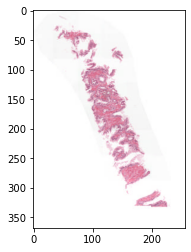

In [8]:
plt.imshow(img);

### Make and resize mask

In [9]:
gray_img = img_as_ubyte(rgb2gray(img))
val = threshold_otsu(gray_img)
manual_mask = gray_img < val
manual_mask = binary_dilation(manual_mask, square(5))

In [10]:
mask_med = resize(manual_mask, tiff_img[1].shape, order=0)

In [11]:
mask_med.dtype

dtype('float64')

In [12]:
assert np.histogram(mask_med, bins=2)[0].sum() == np.prod(mask_med.shape)  # all pixel values are 0 or 1

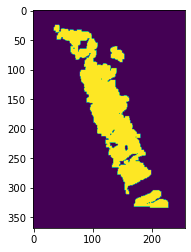

In [13]:
plt.imshow(manual_mask);

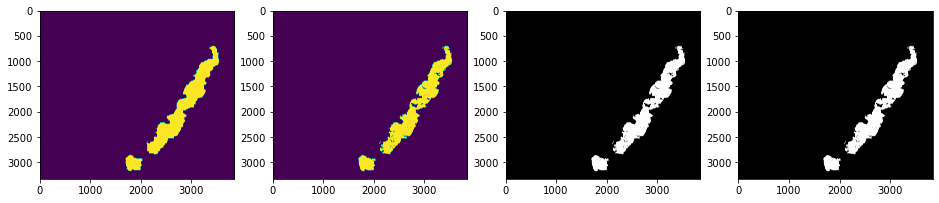

In [315]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(mask_small)
plt.subplot(1,4,2)
plt.imshow(manual_mask)
plt.subplot(1,4,3)
plt.imshow(resize(manual_mask.astype(bool), img[1].shape, order=0))
plt.subplot(1,4,4)
plt.imshow((resize(manual_mask, tiff_img[1].shape) > 0).astype(int) * 255)

## Non-overlapping tiling -- equivalent to strided mask with stride = size of tile

Follows https://www.kaggle.com/c/trends-assessment-prediction/discussion/162836

In [14]:
size = 224
n_tiles = 12

In [16]:
H, W, _ = img.shape
print(img.shape)

(368, 256, 3)


In [17]:
hpad, wpad = (size - H % size) % size, (size - W % size) % size

img_padded  = np.pad(img,  [[hpad // 2, hpad - hpad // 2], [wpad // 2, wpad - wpad // 2], [0,0]], constant_values=255)
mask_padded = np.pad(manual_mask, [[hpad // 2, hpad - hpad // 2], [wpad // 2, wpad - wpad // 2]],        constant_values=0)

In [18]:
Hpadded, Wpadded, _ = img_padded.shape
print(img_padded.shape)

(448, 448, 3)


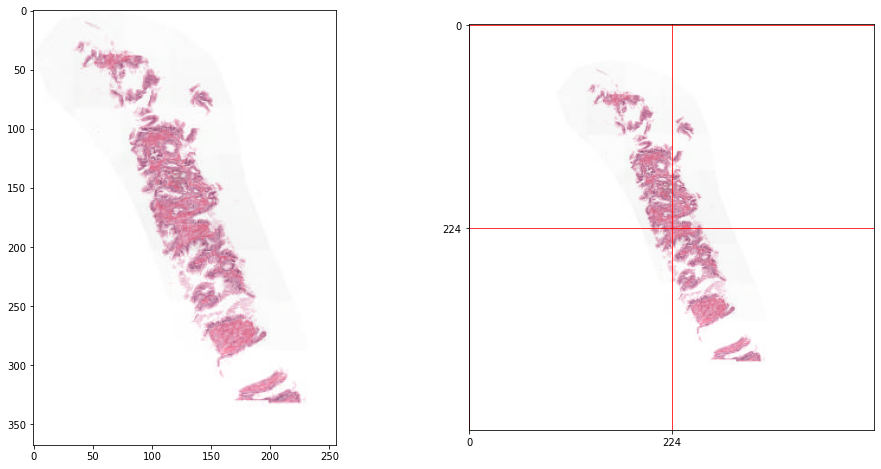

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_padded)
plt.gca().xaxis.set_major_locator(MultipleLocator(size))
plt.gca().yaxis.set_major_locator(MultipleLocator(size))
plt.grid(True, 'major', color='r');

In [20]:
img_tiled = img_padded.reshape(Hpadded // size, size, Wpadded // size, size, 3)
img_tiled = img_tiled.transpose(0,2,1,3,4).reshape(-1, size, size, 3)

mask_tiled = mask_padded.reshape(Hpadded // size, size, Wpadded // size, size, 1)
mask_tiled = mask_tiled.transpose(0,2,1,3,4).reshape(-1, size, size)

In [21]:
print(img_tiled.shape)
print(mask_tiled.shape)

(4, 224, 224, 3)
(4, 224, 224)


### Sorting -- top n

In [23]:
top_n = np.argsort(np.sum(img_tiled, axis=(1,2,3)))[:n_tiles]
img_tiled_top_n = img_tiled[top_n]

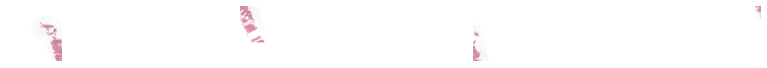

In [24]:
fig, axs = plt.subplots(1, len(img_tiled_top_n), figsize=(16,1))
for ax, tile in zip(axs.flatten(), img_tiled_top_n):
    ax.imshow(tile)
    ax.axis('off')

#### Mean image and mask for the top_n

In [25]:
print(img_tiled_top_n.mean((1,2,3)))
print(mask_tiled[top_n].mean((1,2)))

[246.90148677 247.87657446 251.94766422 254.21586682]
[0.11650989 0.123864   0.043467   0.01387117]


### Sorting -- top area thresholded under the mask

In [26]:
area = np.mean(mask_tiled, axis=(1,2))
thresh = 0.5
top_area = area[area > thresh]
order = np.argsort(-top_area)
img_tiled_top_area = img_tiled[area > thresh][order]
print(img_tiled_top_area.shape)

(0, 224, 224, 3)


In [27]:
fig, axs = plt.subplots(int(np.ceil(len(img_tiled_top_area) / 16)), 16, figsize=(16,6))
for ax, tile in zip(axs.flatten(), img_tiled_top_area):
    ax.imshow(tile)
for ax in axs.flatten(): ax.axis('off')

<Figure size 1152x432 with 0 Axes>

In [28]:
print(img_tiled_top_area.mean((1,2,3)))
print(mask_tiled[area > thresh][order].mean((1,2)))

[]
[]


### Sorting -- top area thresholded under the image

In [29]:
area = np.mean(img_tiled, axis=(1,2,3))
thresh = 220
top_area = area[area < thresh]
order = np.argsort(top_area)
img_tiled_top_area = img_tiled[area < thresh][order]
print(img_tiled_top_area.shape)

(0, 224, 224, 3)


In [30]:
fig, axs = plt.subplots(int(np.ceil(len(img_tiled_top_area) / 16)), 16, figsize=(16,6))
for ax, tile in zip(axs.flatten(), img_tiled_top_area):
    ax.imshow(tile)
for ax in axs.flatten(): ax.axis('off')

<Figure size 1152x432 with 0 Axes>

In [31]:
print(img_tiled_top_area.mean((1,2,3)))
print(mask_tiled[area < thresh][order].mean((1,2)))

[]
[]


## Overlapping mask -- equivalent to strided mask with stride < size of tile

In [335]:
overlap = 0.5
stride = int(size * (1 - overlap))
print(f'stride = {stride}')

stride = 112


In [336]:
print(f'H = {H}, W = {W}')

H = 368, W = 256


In [337]:
# original padding method for 0 overlap
hpad = (size - H % size) % size
wpad = (size - W % size) % size
print(f'hpad = {hpad}, wpad = {wpad}')

hpad = 80, wpad = 192


In [338]:
hpad = int((np.ceil(H / stride) - 1) * stride + size - H)
wpad = int((np.ceil(W / stride) - 1) * stride + size - W)
print(f'hpad = {hpad}, wpad = {wpad}')

hpad = 192, wpad = 192


In [339]:
img_padded  = np.pad(img,  [[hpad // 2, hpad - hpad // 2], [wpad // 2, wpad - wpad // 2], [0,0]], constant_values=255)
mask_padded = np.pad(manual_mask, [[hpad // 2, hpad - hpad // 2], [wpad // 2, wpad - wpad // 2]],        constant_values=0)

In [340]:
print(f'img shape        = {img.shape}')
print(f'img padded shape = {img_padded.shape}')

img shape        = (368, 256, 3)
img padded shape = (560, 448, 3)


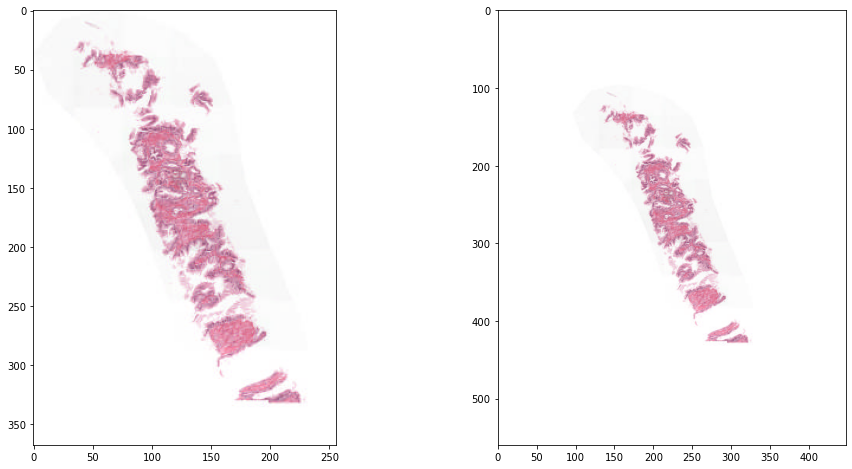

In [341]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_padded);

In [342]:
img.shape

(368, 256, 3)

At 50% overlap and size 224, stride is 112 <br>
256 is covered by 2 tiles of 224 with 50 % overlap <br>
tile coords in padded: 0 : 224, 112 : 336 <br>
padding is 336 - 256 = 80 <br> 
tile coords in orig: -40 : 184, 72 : 296 <br>

<br> 
At 60% overlap and size 224, stride is 89.6 -> 89 <br>
256 is covered by 3 tiles of 224 with 60 % overlap <br>
tile coords in padded: 0 : 224, 89 : 313, 178 : 402 (next tile would be 267 : 491 and 267 is outside original dim) <br>
padding is 402 - 256 = 146 <br> 
tile coords in orig: -44 : 178, 45 : 269, 134 : 358 <br>

In [343]:
(np.ceil(W / stride) - 1) * stride + size - W

192.0

368 is covered by 3 tiles of 224 with 50% overlap <br>
tile coords in padded: 0 : 224, 112 : 336, 224 : 448 <br>
padding is 448 - 368 = 80 <br>
tile coords in orig: -40 : 184, 72 : 296, 184 : 408

In [344]:
np.ceil(H / stride) * stride - H

80.0

In [345]:
print(f'img shape        = {img.shape}')
print(f'img padded shape = {img_padded.shape}')

img shape        = (368, 256, 3)
img padded shape = (560, 448, 3)


In [346]:
# vertical tiles
vcoords = [h for h in range(0,H,stride)]#[:-1]
hcoords = [w for w in range(0,W,stride)]#[:-1]
print('tile coords in padded img')
print(vcoords)
print(hcoords)

tile coords in padded img
[0, 112, 224, 336]
[0, 112, 224]


In [347]:
list(product(vcoords, hcoords))

[(0, 0),
 (0, 112),
 (0, 224),
 (112, 0),
 (112, 112),
 (112, 224),
 (224, 0),
 (224, 112),
 (224, 224),
 (336, 0),
 (336, 112),
 (336, 224)]

In [348]:
tiles = []
for h, w in product(vcoords, hcoords):
    xslice = slice(h, h+size)
    yslice = slice(w, w+size)
    tiles.append(img_padded[xslice, yslice])

In [349]:
len(tiles)

12

In [350]:
print(f'number of tiles = {len(tiles)}; shapes:')
for t in tiles: print(t.shape)

number of tiles = 12; shapes:
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [356]:
np.stack(tiles).shape

(12, 224, 224, 3)

In [351]:
np.all([t.shape[:2] == (size, size) for t in tiles])

True

In [352]:
vcoords_in_orig = [i*stride - hpad // 2 for i in range(len(vcoords))]
hcoords_in_orig = [i*stride - wpad // 2 for i in range(len(hcoords))]

In [353]:
print('tile coords in original image')
print(vcoords_in_orig)
print(hcoords_in_orig)

tile coords in original image
[-96, 16, 128, 240]
[-96, 16, 128]


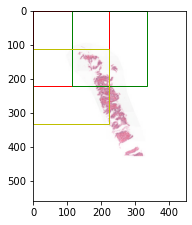

In [354]:
plt.subplot(1,2,1)
plt.imshow(img_padded)
rect = Rectangle((hcoords[0], vcoords[0]), size-3, size-3, color='r', fill=False)
plt.gca().add_artist(rect)
rect = Rectangle((hcoords[1], vcoords[0]), size-3, size-3, color='g', fill=False)
plt.gca().add_artist(rect)
rect = Rectangle((hcoords[0], vcoords[1]), size-3, size-3, color='y', fill=False)
plt.gca().add_artist(rect)

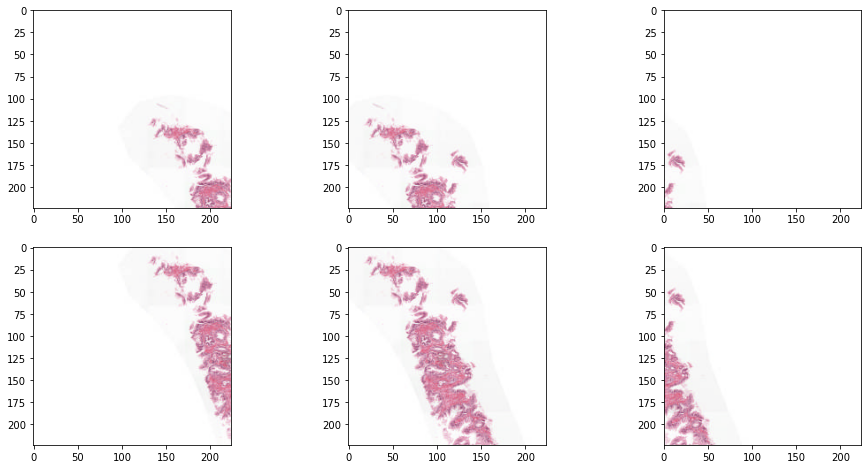

In [355]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
for tile, ax in zip(tiles, axs.flatten()):
    ax.imshow(tile)